Total de registros carregados: 1245480 linhas, 22 colunas

Coluna: temp_max
Q1: 20.00, Q2 (Mediana): 23.00, Q3: 26.00
Média: 22.85, Distância Média-Mediana: 0.15
Outliers encontrados: 2315

Coluna: temp_min
Q1: 19.00, Q2 (Mediana): 22.00, Q3: 25.00
Média: 21.67, Distância Média-Mediana: 0.33
Outliers encontrados: 2208

Coluna: chuva
Q1: 0.00, Q2 (Mediana): 0.00, Q3: 0.00
Média: 0.03, Distância Média-Mediana: 0.03
Outliers encontrados: 10576


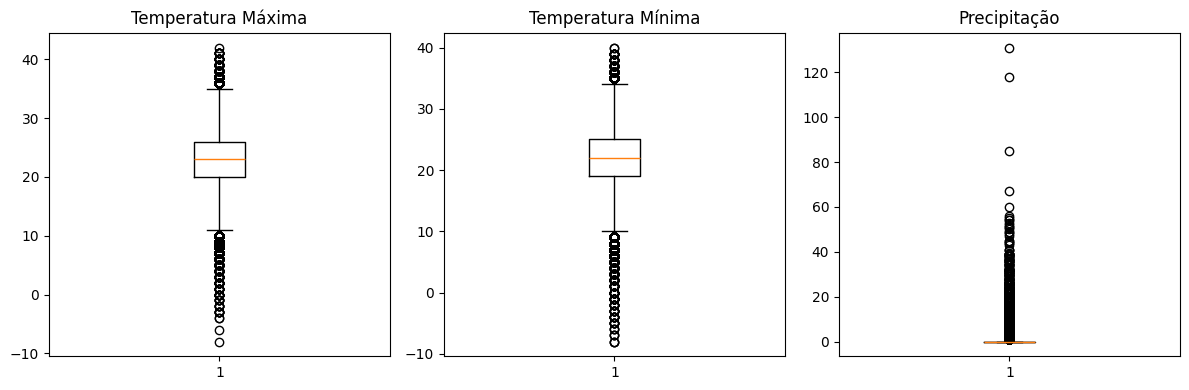


Dias com onda de calor: 16484
Dias com onda de frio: 13619


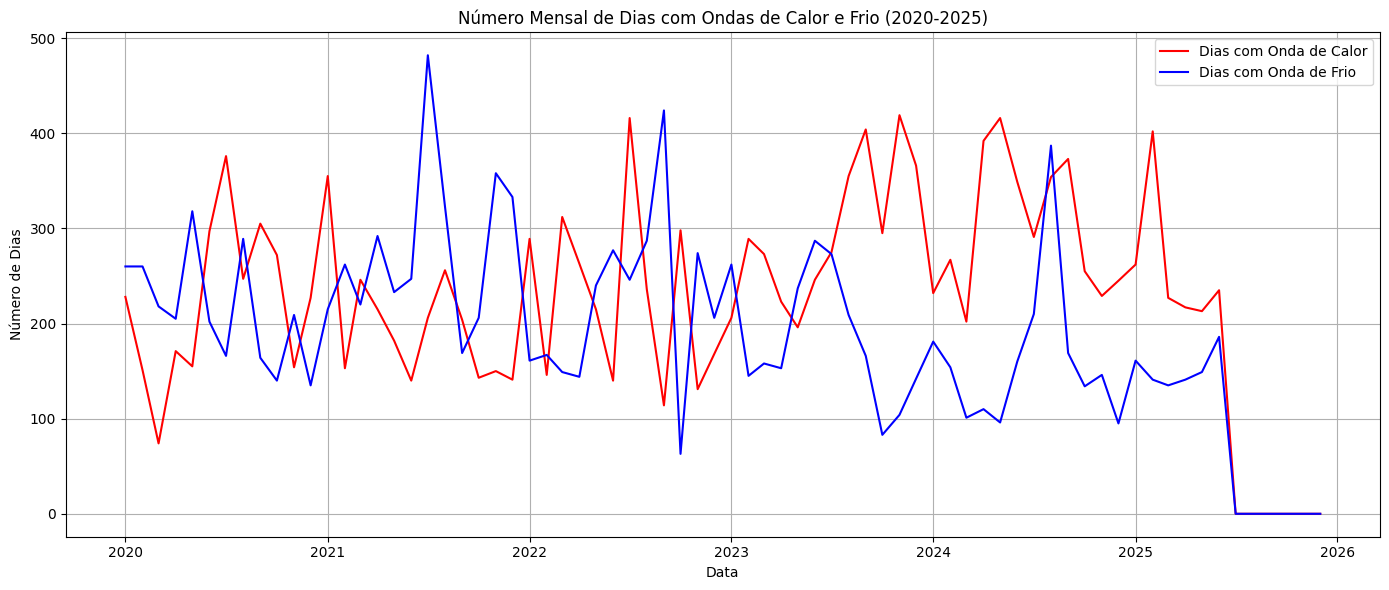

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

pasta = r"C:\Users\Vinicius\Desktop\Projeto\Arquivos para analise\2004-2025"
arquivos = [f for f in os.listdir(pasta) if f.endswith('.csv')]

df_lista = []

for arquivo in arquivos:
    caminho = os.path.join(pasta, arquivo)
    try:
        
        endereco = pd.read_csv(caminho, sep=';', encoding='latin1', nrows=3).iloc[2, 1]

        
        df = pd.read_csv(caminho, sep=';', encoding='latin1', skiprows=8, low_memory=False)

        
        df['arquivo_origem'] = arquivo
        df['endereco_estacao'] = endereco

        df_lista.append(df)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")


df = pd.concat(df_lista, ignore_index=True)

print(f"Total de registros carregados: {df.shape[0]} linhas, {df.shape[1]} colunas")


df.rename(columns={
    'Data': 'data',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'temp_max',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'temp_min',
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'chuva'
}, inplace=True)


df['data'] = pd.to_datetime(df['data'], errors='coerce')


df['temp_max'] = pd.to_numeric(df['temp_max'], errors='coerce')
df['temp_min'] = pd.to_numeric(df['temp_min'], errors='coerce')
df['chuva'] = pd.to_numeric(df['chuva'], errors='coerce')


df = df.dropna(subset=['data'])


df = df[(df['data'].dt.year >= 2020) & (df['data'].dt.year <= 2025)]


def analise_coluna(col):
    q1 = df[col].quantile(0.25)
    q2 = df[col].median()
    q3 = df[col].quantile(0.75)
    media = df[col].mean()
    dist = abs(media - q2)
    iqr = q3 - q1
    outliers = df[(df[col] < (q1 - 1.5*iqr)) | (df[col] > (q3 + 1.5*iqr))]
    print(f"\nColuna: {col}")
    print(f"Q1: {q1:.2f}, Q2 (Mediana): {q2:.2f}, Q3: {q3:.2f}")
    print(f"Média: {media:.2f}, Distância Média-Mediana: {dist:.2f}")
    print(f"Outliers encontrados: {len(outliers)}")
    return outliers

outliers_temp_max = analise_coluna('temp_max')
outliers_temp_min = analise_coluna('temp_min')
outliers_chuva = analise_coluna('chuva')


plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.boxplot(df['temp_max'].dropna())
plt.title('Temperatura Máxima')

plt.subplot(1,3,2)
plt.boxplot(df['temp_min'].dropna())
plt.title('Temperatura Mínima')

plt.subplot(1,3,3)
plt.boxplot(df['chuva'].dropna())
plt.title('Precipitação')

plt.tight_layout()
plt.show()


df['mes'] = df['data'].dt.month

media_historica = df.groupby('mes').agg({
    'temp_max': 'mean',
    'temp_min': 'mean'
}).rename(columns={
    'temp_max': 'media_temp_max',
    'temp_min': 'media_temp_min'
}).reset_index()

df = df.merge(media_historica, on='mes', how='left')

df['desvio_temp_max'] = df['temp_max'] - df['media_temp_max']
df['desvio_temp_min'] = df['temp_min'] - df['media_temp_min']

df['onda_calor_max'] = df['desvio_temp_max'] >= 5
df['onda_frio_min'] = df['desvio_temp_min'] <= -5

print(f"\nDias com onda de calor: {df['onda_calor_max'].sum()}")
print(f"Dias com onda de frio: {df['onda_frio_min'].sum()}")


df['ano'] = df['data'].dt.year

onda_calor_mensal = df[df['onda_calor_max']].groupby(['ano', 'mes']).size().reset_index(name='dias_onda_calor')
onda_frio_mensal = df[df['onda_frio_min']].groupby(['ano', 'mes']).size().reset_index(name='dias_onda_frio')


periodos = pd.MultiIndex.from_product(
    [sorted(df['ano'].unique()), range(1,13)],
    names=['ano', 'mes']
).to_frame(index=False)

onda_calor_mensal = periodos.merge(onda_calor_mensal, on=['ano', 'mes'], how='left').fillna(0)
onda_frio_mensal = periodos.merge(onda_frio_mensal, on=['ano', 'mes'], how='left').fillna(0)

onda_calor_mensal['dias_onda_calor'] = onda_calor_mensal['dias_onda_calor'].astype(int)
onda_frio_mensal['dias_onda_frio'] = onda_frio_mensal['dias_onda_frio'].astype(int)


onda_calor_mensal_ren = onda_calor_mensal.rename(columns={'ano': 'year', 'mes': 'month'})
onda_frio_mensal_ren = onda_frio_mensal.rename(columns={'ano': 'year', 'mes': 'month'})

onda_calor_mensal_ren['data'] = pd.to_datetime(onda_calor_mensal_ren.assign(day=1)[['year', 'month', 'day']])
onda_frio_mensal_ren['data'] = pd.to_datetime(onda_frio_mensal_ren.assign(day=1)[['year', 'month', 'day']])


plt.figure(figsize=(14,6))
plt.plot(onda_calor_mensal_ren['data'], onda_calor_mensal_ren['dias_onda_calor'], label='Dias com Onda de Calor', color='red')
plt.plot(onda_frio_mensal_ren['data'], onda_frio_mensal_ren['dias_onda_frio'], label='Dias com Onda de Frio', color='blue')
plt.title('Número Mensal de Dias com Ondas de Calor e Frio (2020-2025)')
plt.xlabel('Data')
plt.ylabel('Número de Dias')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

media_temp_estacao = df.groupby('endereco_estacao')['temp_max'].mean().reset_index().sort_values(by='temp_max', ascending=False)

print(media_temp_estacao.head())


plt.figure(figsize=(10,6))
plt.barh(media_temp_estacao['endereco_estacao'], media_temp_estacao['temp_max'], color='orange')
plt.xlabel('Média Temperatura Máxima (°C)')
plt.title('Média de Temperatura Máxima por Estação')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:

colunas_exportar = [
    'data',
    'arquivo_origem',
    'endereco_estacao',
    'temp_max',
    'temp_min',
    'chuva',
    'onda_calor_max',
    'onda_frio_min',
    'ano',
    'mes'
]


caminho_saida = r"C:\Users\Vinicius\Desktop\Projeto\analise_meteorologica_para_powerbi.csv"
df[colunas_exportar].to_csv(caminho_saida, index=False, sep=';', encoding='utf-8-sig')

print(f"Arquivo CSV exportado para: {caminho_saida}")


Arquivo CSV exportado para: C:\Users\Vinicius\Desktop\Projeto\analise_meteorologica_para_powerbi.csv
